In [1]:
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import multinomial, dirichlet

%matplotlib inline

In [25]:
class MultinomialExpectationMaximizer:
    def __init__(self, K, rtol=1e-4, max_iter=100, restarts=10):
        self._K = K
        self._rtol = rtol
        self._max_iter = max_iter
        self._restarts = restarts

    def compute_log_likelihood(self, X_test, alpha, beta):
        mn_probs = np.zeros(X_test.shape[0])
        for k in range(beta.shape[0]):
            mn_probs_k = alpha[k] * self._multinomial_prob(X_test, beta[k])
            mn_probs += mn_probs_k
        mn_probs[mn_probs == 0] = np.finfo(float).eps
        return np.log(mn_probs).sum()
    
    def compute_aic(self, X_test, alpha, beta, log_likelihood=None):
        if log_likelihood is None:
            log_likelihood = self.compute_predictive_entropy(X_test, alpha, beta)
        return 2 * (alpha.size + beta.size) - 2 * log_likelihood
    
    def compute_bic(self, X_test, alpha, beta, log_likelihood=None):
        if log_likelihood is None:
            log_likelihood = self.compute_predictive_entropy(X_test, alpha, beta)
        N = X_test.shape[0]
        nb_params = (alpha.shape[0] - 1) + (beta.shape[0] * (beta.shape[1] - 1))
        return -log_likelihood + (0.5 * np.log(N) * nb_params)
    
    def compute_icl_bic(self, bic, gamma):
        classification_entropy = -(np.log(gamma.max(axis=1))).sum()
        return bic + classification_entropy

    def _multinomial_prob(self, counts, beta):
        """
        Evaluates the multinomial probability for a given vector of counts
        counts: (C), vector of counts for a specific observation
        beta: (C), vector of parameters for every component of the multinomial

        Returns:
        p: (1), scalar value for the probability of observing the count vector given the beta parameters
        """
        n = counts.sum(axis=-1)
        m = multinomial(n, beta)
        return m.pmf(counts)

    def _e_step(self, X, alpha, beta):
        """
        Performs E-step on MNMM model
        Each input is numpy array:
        X: (N x C), data points
        alpha: (K), mixture component weights
        beta: (K x C), multinomial categories weights

        Returns:
        gamma: (N x K), probabilities of clusters for objects
        """
        # Compute gamma
        N = X.shape[0]
        K = alpha.shape[0]
        weighted_multi_prob = np.zeros((N, K))
        for k in range(K):
            weighted_multi_prob[:, k] = alpha[k] * self._multinomial_prob(X, beta[k])

        denum = weighted_multi_prob.sum(axis=1)
        gamma = weighted_multi_prob / denum.reshape(-1, 1)

        return gamma

    def _m_step(self, X, gamma):
        """
        Performs M-step on MNMM model
        Each input is numpy array:
        X: (N x C), data points
        gamma: (N x K), probabilities of clusters for objects

        Returns:
        alpha: (K), mixture component weights
        beta: (K x C), mixture categories weights
        """
        # Compute alpha
        alpha = gamma.sum(axis=0) / gamma.sum()

        # Compute beta
        weighted_counts = gamma.T.dot(X)
        beta = weighted_counts / weighted_counts.sum(axis=-1).reshape(-1, 1)

        return alpha, beta

    def _compute_vlb(self, X, alpha, beta, gamma):
        """
        Each input is numpy array:
        X: (N x C), data points
        alpha: (K), mixture component weights
        beta: (K x C), multinomial categories weights
        gamma: (N x K), probabilities of clusters for objects

        Returns value of variational lower bound
        """
        loss = 0
        for k in range(alpha.shape[0]):
            weights = gamma[:, k]
            loss += np.sum(weights * (np.log(alpha[k]) + np.log(self._multinomial_prob(X, beta[k]))))
            loss -= np.sum(weights * np.log(weights))
        return loss

    def _init_params(self, C):
        alpha = np.array([1 / self._K] * self._K)
        beta = dirichlet.rvs([2 * C] * C, self._K)
        return alpha, beta

    def _train_once(self, X):
        loss = float('inf')
        C = X.shape[1]
        alpha, beta = self._init_params(C)

        for it in range(self._max_iter):
            prev_loss = loss
            gamma = self._e_step(X, alpha, beta)
            alpha, beta = self._m_step(X, gamma)
            loss = self._compute_vlb(X, alpha, beta, gamma)
            if it > 0 and (np.abs((prev_loss - loss) / prev_loss) < self._rtol):
                break
        return alpha, beta, gamma, loss

    def fit(self, X):
        '''
        Starts with random initialization *restarts* times
        Runs optimization until saturation with *rtol* reached
        or *max_iter* iterations were made.

        X: (N, C), data points
        K: int, number of clusters
        '''
        best_loss = -float('inf')
        best_alpha = None
        best_beta = None
        best_gamma = None

        for it in range(self._restarts):
            alpha, beta, gamma, loss = self._train_once(X)
            if loss > best_loss:
                best_loss = loss
                best_alpha = alpha
                best_beta = beta
                best_gamma = gamma

        return best_loss, best_alpha, best_beta, best_gamma

In [28]:
def run_em(X, K_max=20, criterion='icl_bic'):
    
    if criterion not in {'icl_bic', 'bic'}:
        raise Exception('Unknown value for criterion: %s' % criterion)

    X = np.vstack(X)
    np.random.shuffle(X)

    nb_train = int(X.shape[0] * 0.8)
    X_train = X[:nb_train]
    X_test = X[nb_train:]

    likelihoods = []
    bics = []
    icl_bics = []
    best_k = -1
    best_alpha = None
    best_beta = None
    best_gamma = None
    prev_criterion = float('inf')
    
    for k in tqdm(range(2, K_max + 1)):
        model = MultinomialExpectationMaximizer(k, restarts=1)
        _, alpha, beta, gamma = model.fit(X_train)
        log_likelihood = model.compute_log_likelihood(X_test, alpha, beta)
        bic = model.compute_bic(X_test, alpha, beta, log_likelihood)
        icl_bic = model.compute_icl_bic(bic, gamma)
        likelihoods.append(log_likelihood)
        bics.append(bic)
        icl_bics.append(icl_bic)

        criterion_cur_value = icl_bic if criterion == 'icl_bic' else bic
        if criterion_cur_value < prev_criterion:
            prev_criterion = criterion_cur_value
            best_alpha = alpha
            best_beta = beta
            best_gamma = gamma
            best_k = k
    
    print('best K = %i' % best_k)
    print('best_alpha: %s' % str(best_alpha))
    print('best_beta: %s' % str(best_beta))
    
    return likelihoods, bics, icl_bics, best_alpha, best_beta, best_gamma

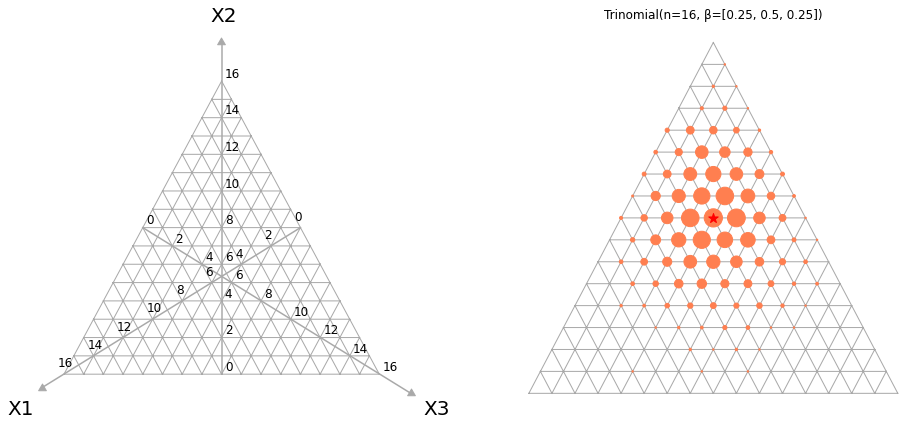

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.lines as lines
from collections import defaultdict


corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
AREA = 0.5 * 1 * 0.75**0.5
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

pairs = [corners[np.roll(range(3), -i)[1:]] for i in range(3)]
# The area of the triangle formed by point xy and another pair or points
tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))

def xy2bc(xy, tol=1.e-4):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    coords = np.array([tri_area(xy, p) for p in pairs]) / AREA
    return np.clip(coords, tol, 1.0 - tol)

def trimesh_coords_to_bucket_counts(trimesh, X):
    bucket_values_to_coord = {tuple(np.round(xy2bc(xy) * 16).astype(np.int)): xy for xy in zip(trimesh.x, trimesh.y)}
    coord_to_counts = defaultdict(int)
    for x in X:
        coord = bucket_values_to_coord[tuple(x)]
        coord_to_counts[coord] += 1
    counts = [coord_to_counts[xy] for xy in zip(trimesh.x, trimesh.y)]
    return counts

def plot_simplex():
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=4)

    fig, axes = plt.subplots(ncols=2, figsize=(16,7.1))
    axes = axes.ravel()
    for ax in axes:
        ax.axis('off')
    axes[0].triplot(trimesh, linewidth=1, color='darkgray')
    axes[1].triplot(trimesh, linewidth=1, color='darkgray')
    axes[1].set_title('Trinomial(n=16, β=[0.25, 0.5, 0.25])')
    
    tick_spacement = 1/16
    height = 0.75**0.5
    
    ax = axes[0]
    
    ax.text(-0.18, -0.12, 'X1', size=20)
    tick_x = 0
    tick_y = 0
    for i in range(17):
        if i % 2 == 0:
            ax.text(tick_x - 0.02, tick_y + 0.02, str(16-i), size=12)
        tick_x += height**2/16
        tick_y += 0.5*height/16

    dim_l1 = lines.Line2D([height**2, -0.07], [0.5*height, -0.04], linestyle='-', color='darkgray')
    ax.add_line(dim_l1)
    ax.scatter([-0.07], [-0.04], marker=(3, 0, 0), s=80, color='darkgray')

    # X2 axis
    ax.text(0.465, 1.04, 'X2', size=20)
    tick_y = 0
    for i in range(17):
        if i % 2 == 0:
            ax.text(0.51, tick_y + 0.01, str(i), size=12)
        tick_y += height/16
        
    dim_l2 = lines.Line2D([0.5, 0.5], [0, 0.98], linestyle='-', color='darkgray')
    ax.add_line(dim_l2)
    ax.scatter([0.498], [0.98], marker=(3, 0, 0), s=80, color='darkgray')

    # X3 axis
    ax.text(1.14, -0.12, 'X3', size=20)

    tick_x = 0.25
    tick_y = height/2
    for i in range(17):
        if i % 2 == 0:
            ax.text(tick_x + 0.01, tick_y + 0.01, str(i), size=12)
        tick_x += height**2/16
        tick_y -= 0.5*height/16

    dim_l3 = lines.Line2D([0.25, 1.1], [height/2, -(0.08/2**0.5)], linestyle='-', color='darkgray')
    ax.add_line(dim_l3)
    ax.scatter([1.1], [-(0.08/2**0.5)], marker=(3, 0, i*90), s=80, color='darkgray')


    return trimesh
    
def plot_trinomial(trimesh, x, color, n=None):
    n = n if n is not None else x.sum()
    counts = trimesh_coords_to_bucket_counts(trimesh, x)
    plt.scatter(x=trimesh.x, y=trimesh.y, color=color, 
                zorder=100,
                s=(np.array(counts) / n)*100000)

def plot_trinomials(X, colors):
    trimesh = plot_simplex()
    n = np.sum([x.sum() for x in X])
    for x, color in zip(X, colors):
        plot_trinomial(trimesh, x, color, n)

def make_dataset(n, alpha, beta):
    xs = []
    for k, alpha_k in enumerate(alpha):
        n_k = int(n * alpha_k)
        x = multinomial.rvs(n=16, p=beta[k], size=n_k)
        xs.append(x)
    return xs

alpha = [1/3]
beta = np.array([[0.25, 0.25, 0.5]])
X = make_dataset(10000, alpha, beta)
colors = ['coral']

plot_trinomials(X, colors)
plt.scatter([0.5], [((0.75**0.5)*0.5)], marker='*', s=100, color='red', zorder=100)

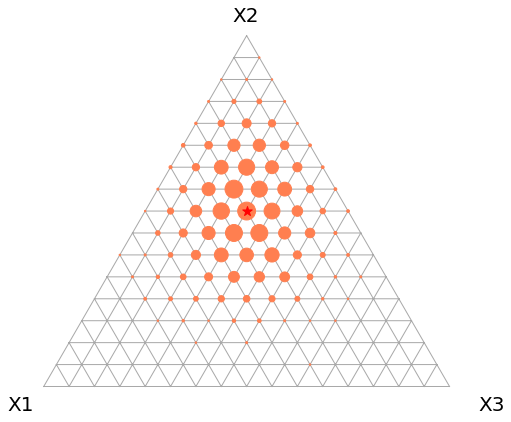

In [5]:
def plot_simplex():
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=4)

    fig, ax = plt.subplots(figsize=(8,7.1))
    ax.axis('off')
    plt.triplot(trimesh, linewidth=1, color='darkgray')
    
    ax.text(-0.09, -0.06, 'X1', size=20)
    ax.text(0.465, 0.9, 'X2', size=20)
    ax.text(1.07, -0.06, 'X3', size=20)
    
    tick_spacement = 1/16

    return trimesh

alpha = [1/3]
beta = np.array([[0.25, 0.25, 0.5]])
X = make_dataset(10000, alpha, beta)
colors = ['coral']

plot_trinomials(X, colors)
plt.scatter([0.5], [((0.75**0.5)*0.5)], marker='*', s=100, color='red', zorder=100)

In [6]:
def plot_em_run(likelihoods, ax):
    Ks = list(range(2, len(likelihoods) + 2))
    ax.scatter(Ks, likelihoods)
    ax.set_title('Likelihood by values of K')
    ax.set_ylabel('Likelihood')
    ax.set_xticks(Ks)
    ax.set_xticklabels(Ks)
    ax.set_xlabel('K')

def plot_simplex(ax):
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=4)

    ax.triplot(trimesh, linewidth=1, color='darkgray')
    ax.axis('off')
    
    ax.text(-0.09, -0.06, 'X1', size=20)
    ax.text(0.465, 0.9, 'X2', size=20)
    ax.text(1.07, -0.06, 'X3', size=20)
    
    tick_spacement = 1/16

    return trimesh

def plot_trinomial(trimesh, x, color, ax, z, n=None):
    n = n if n is not None else x.sum()
    counts = trimesh_coords_to_bucket_counts(trimesh, x)
    ax.scatter(x=trimesh.x, y=trimesh.y, color=color, 
               zorder=z,
               s=(np.array(counts) / n)*100000)

def plot_trinomials(X, colors, ax):
    trimesh = plot_simplex(ax)
    n = np.sum([x.sum() for x in X])
    z=100
    for x, color in zip(X, colors):
        plot_trinomial(trimesh, x, color, ax, z, n)
        z -= 1

In [ ]:
def make_dataset(n, alpha, beta):
    xs = []
    for k, alpha_k in enumerate(alpha):
        n_k = int(n * alpha_k)
        x = multinomial.rvs(n=16, p=beta[k], size=n_k)
        xs.append(x)
    return xs

100%|██████████| 19/19 [00:07<00:00,  2.70it/s]


best K = 4
best_alpha: [0.09878006 0.40812085 0.39687105 0.09622804]
best_beta: [[0.09853841 0.8000628  0.10139879]
 [0.7978293  0.1081376  0.09403309]
 [0.80038963 0.09220514 0.10740523]
 [0.09787359 0.09938163 0.80274478]]


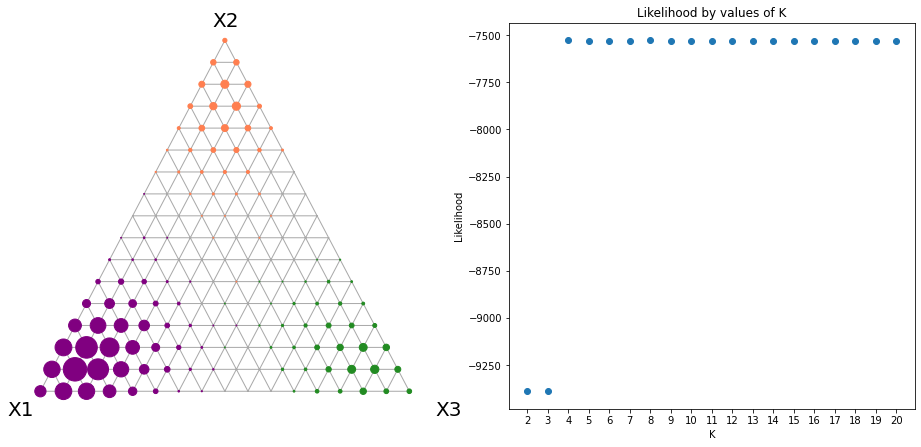

In [7]:
alpha = [0.1, 0.1, 0.8]
beta = np.array([[0.1, 0.1, 0.8], 
                 [0.1, 0.8, 0.1], 
                 [0.8, 0.1, 0.1]])
X = make_dataset(10000, alpha, beta)
colors = ('coral', 'forestgreen', 'purple')

likelihoods, bics, icl_bics, best_alpha, best_beta, best_gamma = run_em(X, criterion='bic')

fig, axes = plt.subplots(ncols=2, figsize=(16, 7.1))
axes = axes.ravel()
plot_trinomials(X, colors, axes[0])
plot_em_run(likelihoods, axes[1])

100%|██████████| 19/19 [08:53<00:00, 28.09s/it]


best K = 3
best_alpha: [0.22831969 0.48609567 0.28558464]
best_beta: [[0.27705915 0.30322099 0.41971985]
 [0.37947026 0.30017264 0.32035709]
 [0.29843845 0.41595892 0.28560263]]


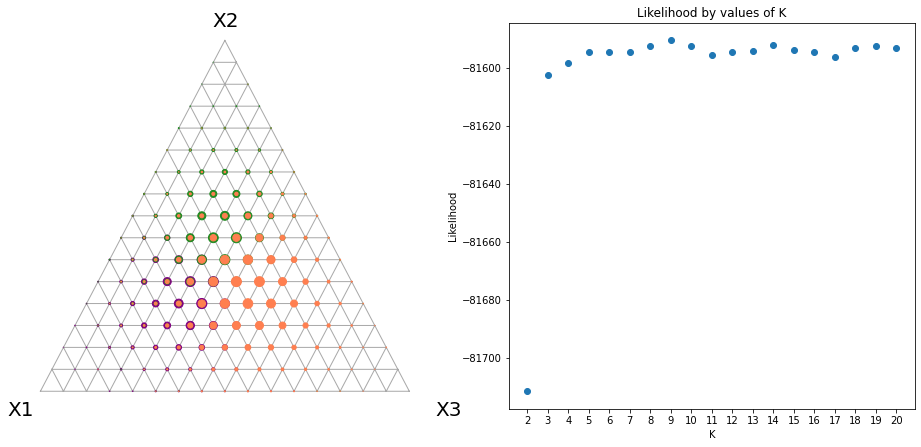

In [26]:
alpha = [1/3]*3
beta = np.array([[0.3, 0.4, 0.3], 
                 [0.3, 0.3, 0.4], 
                 [0.4, 0.3, 0.3]])
X = make_dataset(100000, alpha, beta)
colors = ('coral', 'forestgreen', 'purple')

likelihoods, bics, icl_bics, best_alpha, best_beta, best_gamma = run_em(X, criterion='bic')

fig, axes = plt.subplots(ncols=2, figsize=(16, 7.1))
axes = axes.ravel()
plot_trinomials(X, colors, axes[0])
plot_em_run(likelihoods, axes[1])

In [22]:
def plot_em_run_full(likelihoods, bics):
    fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
    axes = axes.ravel()

    Ks = list(range(2, len(likelihoods) + 2))
    axes[0].scatter(Ks, likelihoods)
    axes[0].set_title('Likelihood by values of K')
    axes[0].set_ylabel('Likelihood')

    axes[1].scatter(Ks, bics)
    axes[1].scatter(np.argmin(bics) + 2, np.min(bics), color='red')
    axes[1].set_title('BIC by values of K')
    axes[1].set_ylabel('BIC')

    for ax in axes:
        ax.set_xticks(Ks)
        ax.set_xticklabels(Ks)
        ax.set_xlabel('K')

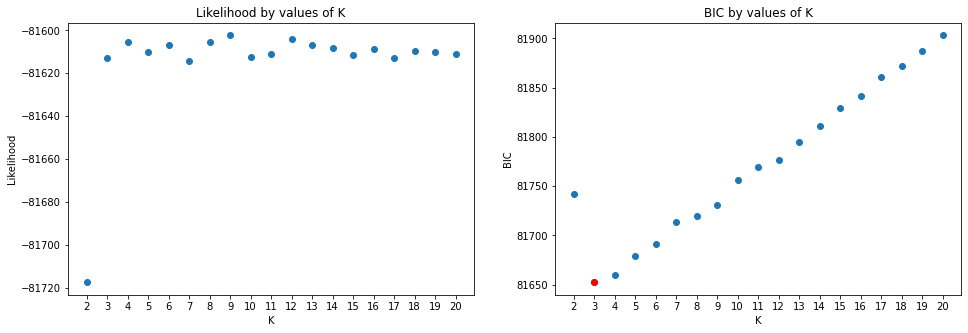

In [23]:
plot_em_run_full(likelihoods, bics)

100%|██████████| 19/19 [01:38<00:00,  5.18s/it]


best K = 11
best_alpha: [0.0541163  0.1179755  0.0651013  0.09980542 0.12718092 0.06444659
 0.10059403 0.07236515 0.1275953  0.09613049 0.074689  ]
best_beta: [[0.27806732 0.36889875 0.35303393]
 [0.6912923  0.10780336 0.20090434]
 [0.2833952  0.51785939 0.19874541]
 [0.09385664 0.51841    0.38773337]
 [0.45155008 0.09301747 0.45543245]
 [0.44713478 0.30827496 0.24459026]
 [0.11066688 0.31812004 0.57121308]
 [0.45714883 0.34073309 0.20211809]
 [0.11257375 0.10601884 0.78140742]
 [0.10789805 0.70439117 0.18771078]
 [0.28294664 0.15469011 0.56236325]]


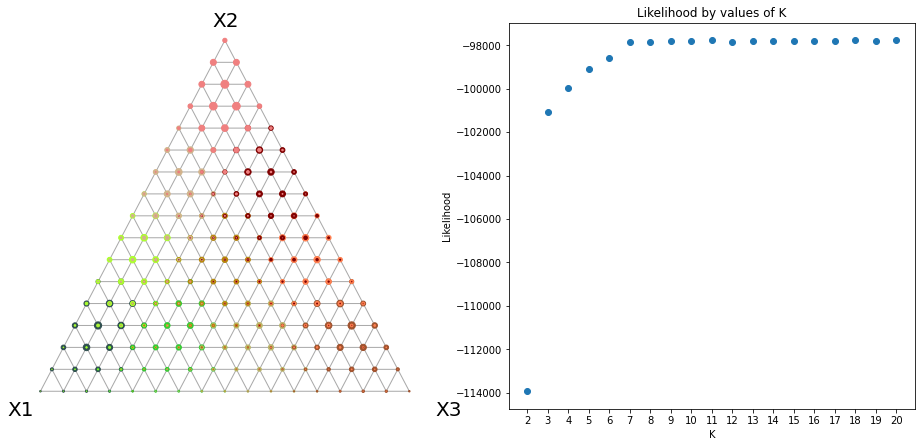

In [29]:
alpha = [1/10]*10
beta = np.array([[0.1, 0.1, 0.8], 
                 [0.1, 0.3, 0.6], 
                 [0.1, 0.5, 0.4], 
                 [0.1, 0.7, 0.2], 
                 [0.3, 0.1, 0.6], 
                 [0.3, 0.3, 0.4], 
                 [0.3, 0.5, 0.2], 
                 [0.5, 0.1, 0.4],
                 [0.5, 0.3, 0.2],
                 [0.7, 0.1, 0.2]])
X = make_dataset(100000, alpha, beta)
colors = ('lightcoral', 'maroon', 'coral', 'sienna', 'tan', 'darkgoldenrod', 'darkkhaki', 'greenyellow', 'limegreen', 'darkslategrey')

likelihoods, bics, icl_bics, best_alpha, best_beta, best_gamma = run_em(X, criterion='bic')

fig, axes = plt.subplots(ncols=2, figsize=(16, 7.1))
axes = axes.ravel()
plot_trinomials(X, colors, axes[0])
plot_em_run(likelihoods, axes[1])

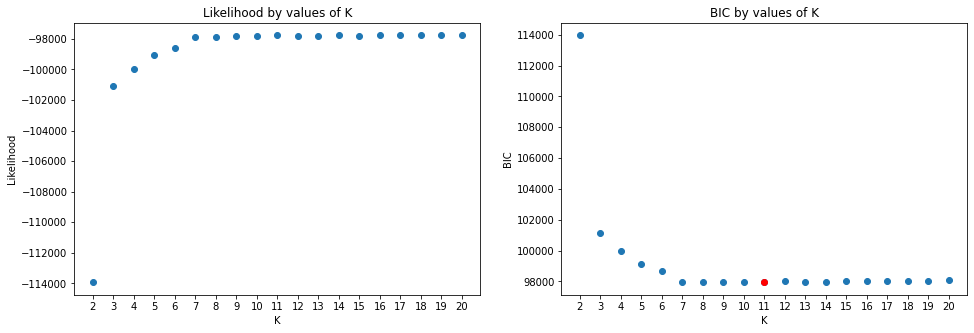

In [30]:
plot_em_run_full(likelihoods, bics)